# Couple candlesticks - Trap - Detection(Predict, Classification, Clustering)

In [66]:
# Kind v1 - 1 trong so 2 cay nen la shaven head hoac shaven bottom

### Import Library

In [67]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

### Load Price Data

In [68]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [69]:
df = dataset.copy()

In [70]:
data = df[(df.index > '2020-11-01 00:00:00') & (df.index < '2024-10-01 00:00:00')].copy()

In [71]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if 100 * r.name.hour + r.name.minute == 1425:
        return signal
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [72]:
# Couple candlesticks signal
data['low_s1'] = data['Low'].shift(1)
data['high_s1'] = data['High'].shift(1)
data['max_5'] = data['High'].rolling(5).max()
data['min_5'] = data['Low'].rolling(5).min()
data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
data['condition_1'] = data['condition_1'].shift(1)
data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
data['signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)

## Trap labeling

In [73]:
traps = []
for i, row in data.iterrows():
    if row['signal']:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
        if not len(data_to_end_day):
            traps.append(1)
            continue
        #
        if row['signal'] == 'short':
            if len(data_to_end_day[data_to_end_day.High > row['Close'] + 3.5]) > 0:
                traps.append(1)
            else:
                traps.append(0)
        else:
            if len(data_to_end_day[data_to_end_day.Low < row['Close'] - 3.5]) > 0:
                traps.append(1)
            else:
                traps.append(0)
    else:
        traps.append(0)

In [74]:
data['trap'] = traps

## 8.Clustering by 

## 7. Clustering by min-max-10 & min-max-52 & Close

In [137]:
# del signal_data, feature_cols, cluster, group_by_cluster
df7 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
df7['max_10'] = df7['High'].rolling(10).max()
df7['min_10'] = df7['Low'].rolling(10).min()
df7['max_52'] = df7['High'].rolling(52).max()
df7['min_52'] = df7['Low'].rolling(52).min()
#
signal_data = df7[df7.signal != '']
signal_data.dropna(inplace=True)
#
feature_cols = ["Close", "max_10", "min_10", "max_52", "min_52"]
cluster = KMeans(n_clusters=30, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

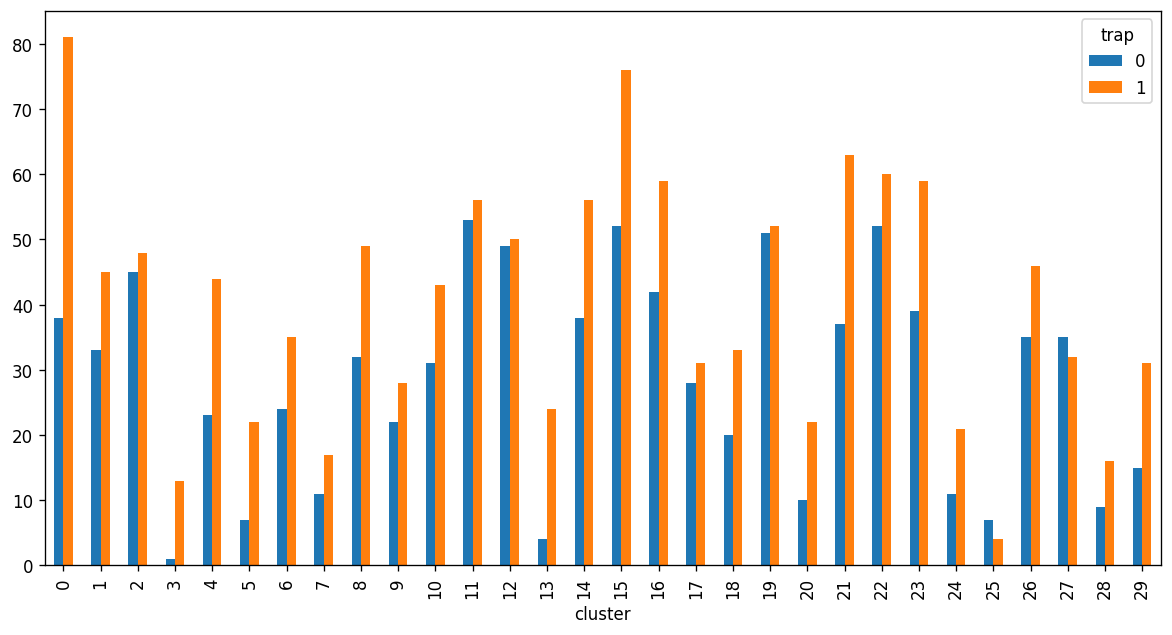

In [138]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 6. Clustering by Min_max-10 & Close

In [135]:
# del signal_data, feature_cols, cluster, group_by_cluster
df6 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
df6['max_10'] = df6['High'].rolling(10).max()
df6['min_10'] = df6['Low'].rolling(10).min()
#
signal_data = df6[df6.signal != '']
signal_data.dropna(inplace=True)
#
feature_cols = ["Close", "max_10", "min_10"]
cluster = KMeans(n_clusters=30, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

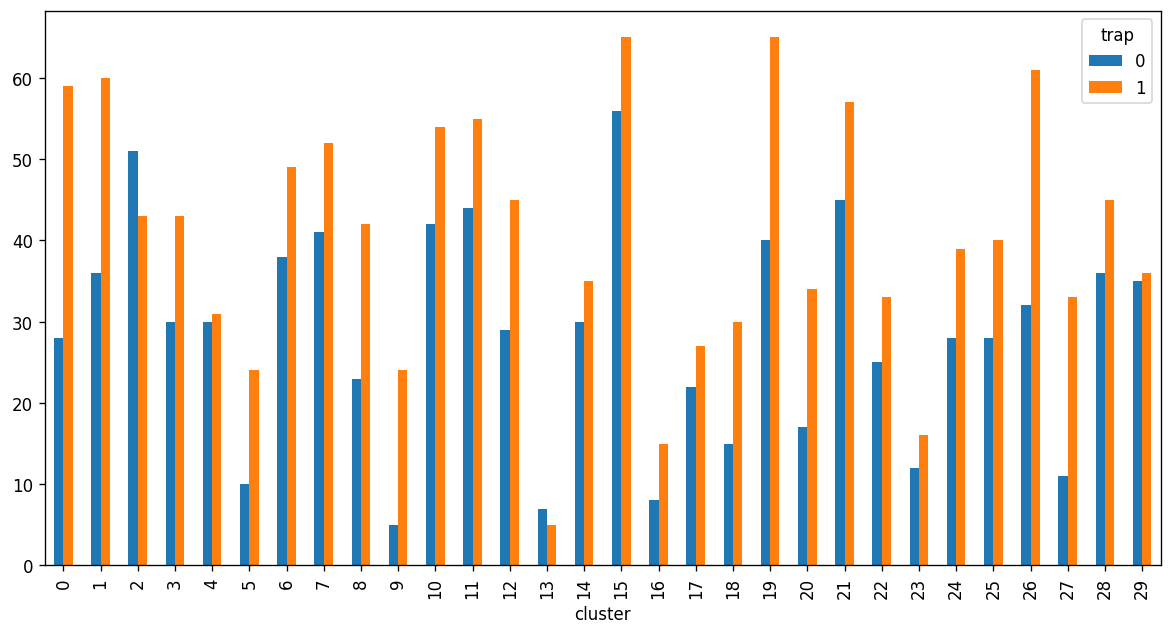

In [136]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 5. Clustering by diff Min_max-10 & diff Open-prev_Open

In [124]:
# del signal_data, feature_cols, cluster, group_by_cluster
df5 = data[["Open", "Close", "High", "Low", "Volume", "signal", "trap"]].copy()
df5['prev_Open'] = df5['Open'].shift(1)
df5['diff_open'] = df5['Open'] - df5['prev_Open']
df5['max_10'] = df5['High'].rolling(10).max()
df5['min_10'] = df5['Low'].rolling(10).min()
df5['diff_10'] = df5['max_10'] - df5['min_10']
#
signal_data = df5[df5.signal != '']
signal_data.dropna(inplace=True)
# quantile signal data
deq_low = signal_data["diff_open"].quantile(0.01)
deq_high  = signal_data["diff_open"].quantile(0.99)
dvq_low = signal_data["diff_10"].quantile(0.01)
dvq_high  = signal_data["diff_10"].quantile(0.99)
signal_data = signal_data[(signal_data["diff_open"] < deq_high) & (signal_data["diff_open"] > deq_low) & (signal_data["diff_10"] < dvq_high) & (signal_data["diff_10"] > dvq_low)]
#
feature_cols = ["diff_open", "diff_10"]
cluster = KMeans(n_clusters=10, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

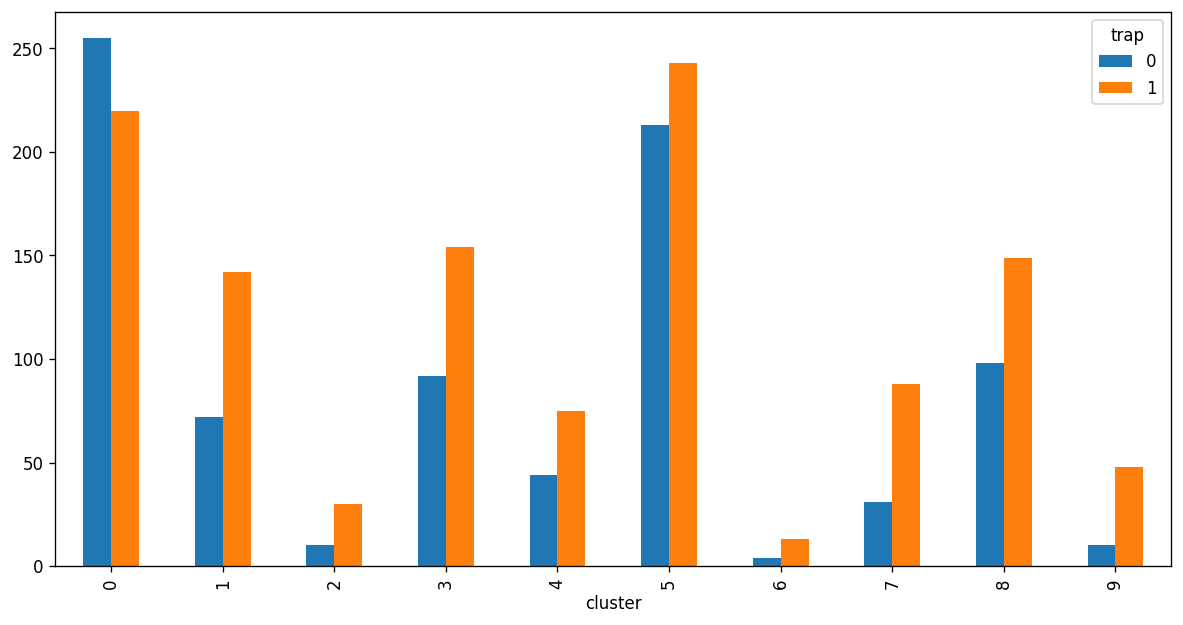

In [116]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 4. Clustering by diff EMA & diff avg Volume of 5 last bars

In [109]:
del signal_data, feature_cols, cluster, group_by_cluster
df4 = data[["Open", "Close", "High", "Low", "Volume", "signal", "trap"]].copy()
df4['avg_vol'] = df4["Volume"].rolling(20).mean()
df4['diff_vol'] = df4["Volume"] - df4["avg_vol"]
df4['diff_vol_s1'] = df4['diff_vol'].shift(1)
df4['diff_vol_s2'] = df4['diff_vol'].shift(2)
df4['diff_vol_s3'] = df4['diff_vol'].shift(3)
df4['diff_vol_s4'] = df4['diff_vol'].shift(4)
# df4['diff_vol_s5'] = df4['diff_vol'].shift(5)
#
df4["ema"] = ta.ema(df4["Close"], length=20)
df4['diff_ema'] = df4["Close"] - df4["ema"]
df4['diff_ema_s1'] = df4['diff_ema'].shift(1)
df4['diff_ema_s2'] = df4['diff_ema'].shift(2)
df4['diff_ema_s3'] = df4['diff_ema'].shift(3)
df4['diff_ema_s4'] = df4['diff_ema'].shift(4)
# df4['diff_ema_s5'] = df4['diff_ema'].shift(5)
#
signal_data = df4[df4.signal != '']
signal_data.dropna(inplace=True)
# quantile signal data
deq_low = signal_data["diff_ema"].quantile(0.01)
deq_high  = signal_data["diff_ema"].quantile(0.99)
dvq_low = signal_data["diff_vol"].quantile(0.01)
dvq_high  = signal_data["diff_vol"].quantile(0.99)
signal_data = signal_data[(signal_data["diff_ema"] < deq_high) & (signal_data["diff_ema"] > deq_low) & (signal_data["diff_ema"] < dvq_high) & (signal_data["diff_ema"] > dvq_low)]
#
feature_cols = ["diff_vol", "diff_vol_s1", "diff_vol_s2", "diff_vol_s3", "diff_vol_s4", "diff_ema", "diff_ema_s1", "diff_ema_s2", "diff_ema_s3", "diff_ema_s4"]
cluster = KMeans(n_clusters=10, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

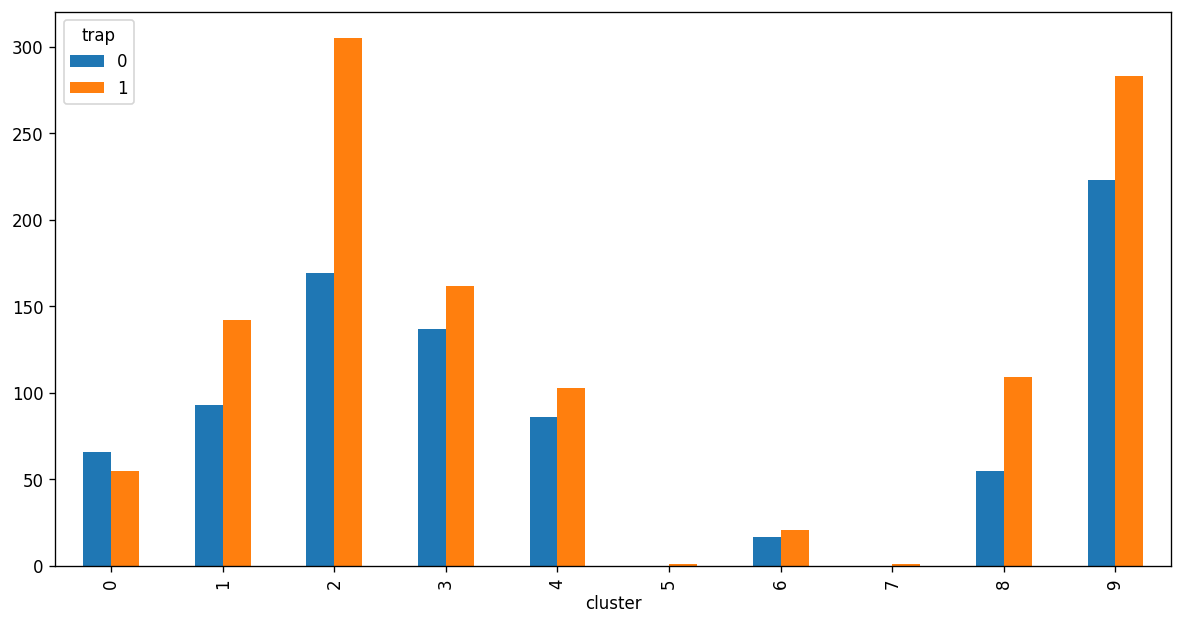

In [112]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 3. Clustering by price_move & min-max-10 bars

In [75]:
del signal_data, feature_cols, cluster, group_by_cluster
df3 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
df3['price_move'] = df3['Close'] - df3['Close'].shift(1)
df3['price_move'] = round(df3['price_move'], 1)
#
df3['max_10'] = df3['High'].shift(1).rolling(10).max()
df3['min_10'] = df3['Low'].shift(1).rolling(10).min()
df3['diff_to_max10'] = df3['Close'] / df3['max_10']
df3['diff_to_max10'] = round(df3['diff_to_max10'], 3)
df3['diff_to_min10'] = df3['Close'] / df3['min_10']
df3['diff_to_min10'] = round(df3['diff_to_min10'], 3)
#
signal_data = df3[df3.signal != '']
signal_data.dropna(inplace=True)
feature_cols = ["price_move", "diff_to_max10", "diff_to_min10"]
cluster = KMeans(n_clusters=10, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

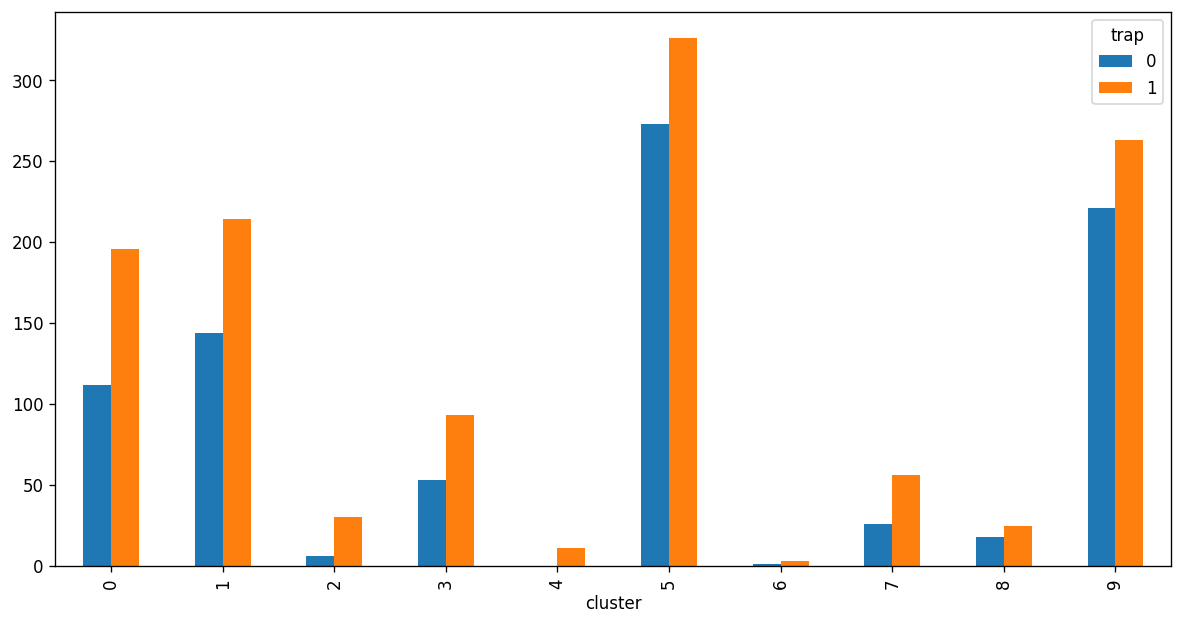

In [76]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 2. Clustering by price move & RSI

In [88]:
del signal_data, feature_cols, cluster, group_by_cluster
df2 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
df2['RSI'] = ta.rsi(df2["Close"], length=14)
df2['RSI'] = round(df2['RSI'])
df2['price_move'] = df2['Close'] - df2['Close'].shift(1)
df2['price_move'] = round(df2['price_move'], 1)
signal_data = df2[df2.signal != '']
signal_data.dropna(inplace=True)
feature_cols = ["RSI", "price_move"]
cluster = KMeans(n_clusters=10, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

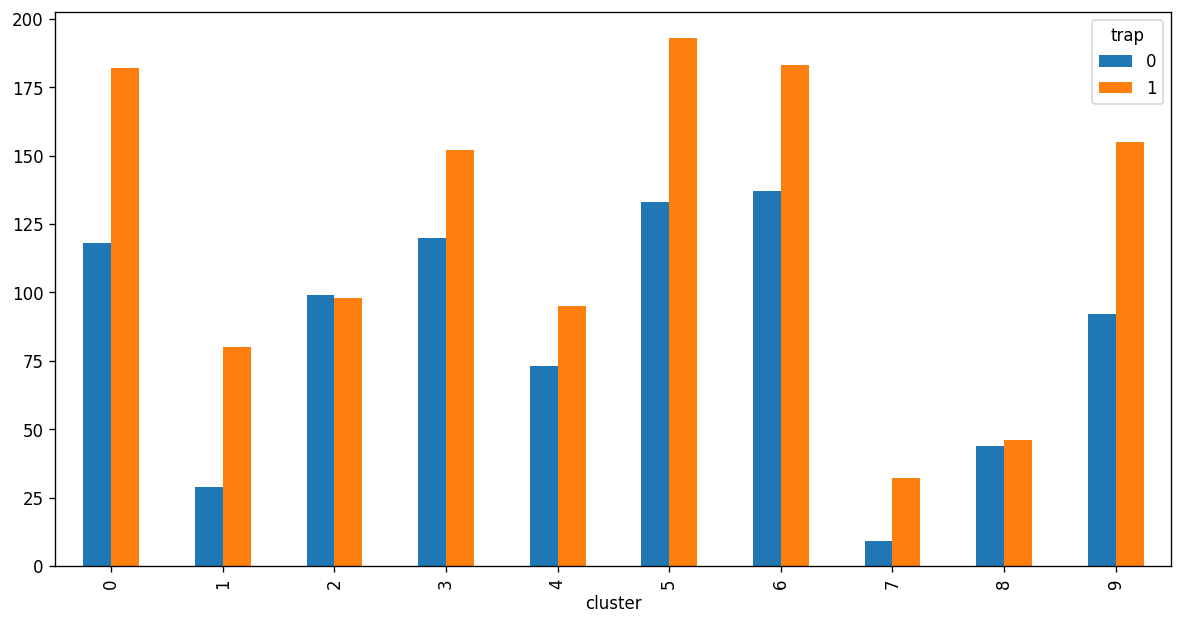

In [89]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()

## 1. Clustering by RSI & min-max before

In [79]:
del signal_data, feature_cols, cluster, group_by_cluster
df1 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
df1['RSI'] = ta.rsi(df1["Close"], length=14)
df1['RSI'] = round(df1['RSI'])
#
df1['max_close10'] = df1['Close'].shift(1).rolling(10).max()
df1['min_close10'] = df1['Close'].shift(1).rolling(10).min()
df1['diff_to_max10'] = df1['Close'] / df1['max_close10']
df1['diff_to_max10'] = round(df1['diff_to_max10'], 3)
df1['diff_to_min10'] = df1['Close'] / df1['min_close10']
df1['diff_to_min10'] = round(df1['diff_to_min10'], 3)
#
df1['max_close50'] = df1['Close'].shift(1).rolling(50).max()
df1['min_close50'] = df1['Close'].shift(1).rolling(50).min()
df1['diff_to_max50'] = df1['Close'] / df1['max_close50']
df1['diff_to_max50'] = round(df1['diff_to_max50'], 3)
df1['diff_to_min50'] = df1['Close'] / df1['min_close50']
df1['diff_to_min50'] = round(df1['diff_to_min50'], 3)

In [80]:
signal_data = df1[df1.signal != '']
signal_data.dropna(inplace=True)

In [81]:
# signal_data.isnull().any()

In [82]:
feature_cols = ["RSI", "diff_to_max10", "diff_to_min10", "diff_to_max50",
                         "diff_to_min50"]
cluster = KMeans(n_clusters=10, n_init=2).fit(signal_data[feature_cols])
signal_data = signal_data.assign(cluster=cluster.labels_)

<Axes: xlabel='cluster'>

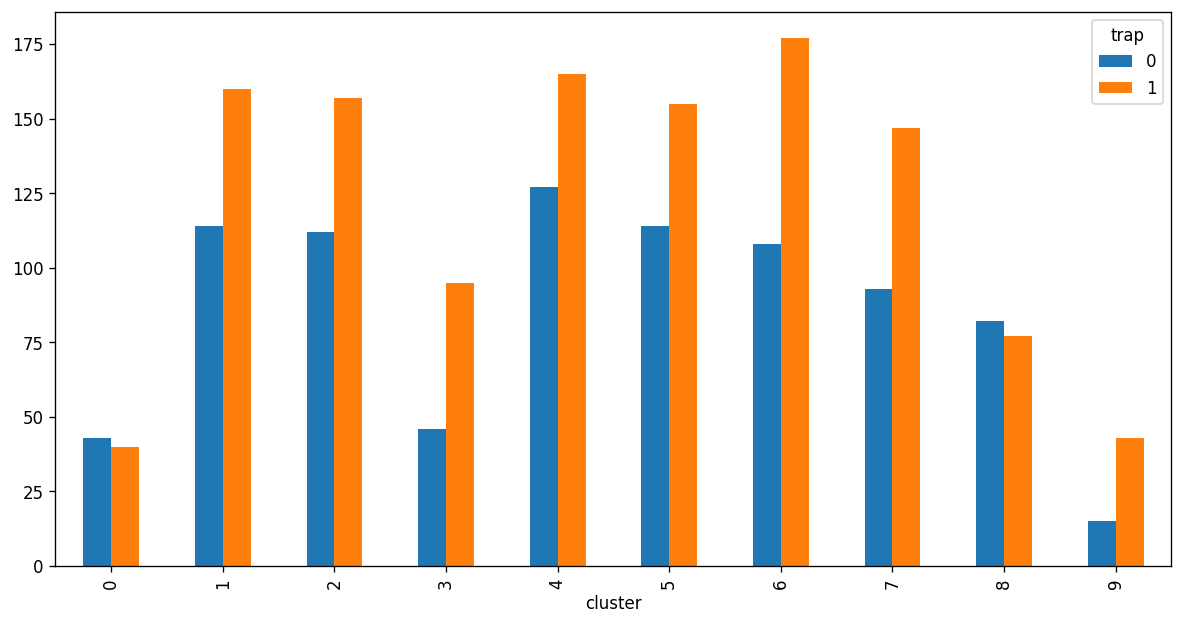

In [83]:
group_by_cluster = signal_data.groupby(['cluster', 'trap'])['cluster'].count().rename({'cluster': 'count'})
group_by_cluster.unstack().plot.bar()